Alex Gagliano, 05/10/2020

Let's start by importing our required packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from astropy.time import Time
from collections import Counter

sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")


plt.rcParams['xtick.major.size'] = 16
plt.rcParams['ytick.major.size'] = 16

plt.rcParams['xtick.minor.size'] = 8
plt.rcParams['ytick.minor.size'] = 8
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [23]:
logL = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/scripts/superbol/SBO_input/superbol_output_2020oi/logL_bb_2020oi_AUBgVriz.txt", delimiter='\t', header=None, names=['MJD', 'logL', 'logLerr'])

logL_old = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/scripts/superbol/superbol_output_2020oi/logL_bb_2020oi_AUBgVriz.txt")


In [24]:
logL_old

,MJD,logL,logLerr,Quality,ph
0,58856.000,41.728,0.088,Bad,-9.000
1,58856.566,41.873,0.092,Great,-8.434
2,58857.131,41.980,0.095,Bad,-7.869
3,58857.697,42.059,0.098,Great,-7.303
4,58858.263,42.124,0.099,Great,-6.737
...,...,...,...,...,...
95,58909.737,41.398,0.067,Bad,44.737
96,58910.303,41.387,0.066,Great,45.303
97,58910.869,41.376,0.066,Bad,45.869
98,58911.434,41.364,0.066,Bad,46.434


In [65]:
logL

,MJD,logL,logLerr
0,58856.000,38.419,0.061
1,58856.127,38.419,0.061
2,58856.253,39.562,0.023
3,58856.380,41.370,0.026
4,58856.507,41.718,0.032
...,...,...,...
495,58918.693,41.321,0.119
496,58918.820,41.320,0.119
497,58918.947,41.318,0.119
498,58919.073,41.317,0.119


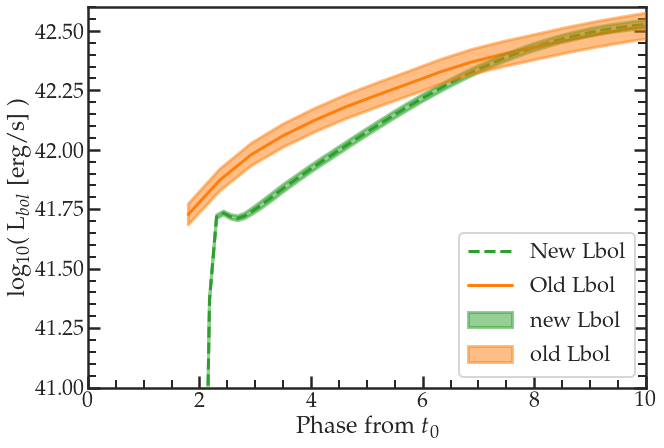

In [95]:
t0 = 58854.2

sns.set_context("poster")

plt.figure(figsize=(10,7))
plt.plot(logL['MJD']-t0, logL['logL'], '--', lw=3, label='New Lbol',c='tab:green')
plt.fill_between(logL['MJD']-t0, logL['logL']-logL['logLerr']/4., logL['logL']+logL['logLerr']/4., color="tab:green", lw=3, alpha=0.5, label='new Lbol', zorder=100)

plt.fill_between(logL_old['MJD']-t0, logL_old['logL']-logL_old['logLerr']/2., logL_old['logL']+logL_old['logLerr']/2., color='tab:orange', lw=3, alpha=0.5, label='old Lbol', zorder=100)

plt.plot(logL_old['MJD']-t0, logL_old['logL'], lw=3, label='Old Lbol', c='tab:orange')
plt.legend()
plt.xlabel(r"Phase from $t_0$")
plt.ylabel(r"log$_{10}$( L$_{bol}$ [erg/s] )")
plt.ylim((41, 42.6))
plt.xlim((0, 10))
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/SBO_Lbol_Superbol_Zoom.png",dpi=300, bbox_inches='tight')

And, fitting both the rise and decline: 

A pretty good fit! This will serve as our mean model for this data - we'll now use George to create a gaussian process to fit the data a little more closely. 

In [78]:
# Lobs = integrate observed fluxes with no BB fit
# L+BB = observed flux + BB fit extrapolation
# See logL_obs_2020oi_ABgVriz.txt and logL_bb_2020oi_ABgVriz.txt for simple LC files
# Methodology:
# filters used:ABgVriz
# redshift used:31.16
# extinction used:0.173
# Wavelengths used in observer frame (data already K-corrected?)
# Single BB fit to all wavelengths, with no UV suppression

t0 = 58854.2

In [79]:
BBparams_superbol = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/scripts/superbol/SBO_input/superbol_output_2020oi/BB_params_2020oi_AUBgVriz.txt", delimiter='\t')

In [80]:
#t=8 days
#TBB= 9679 K.
#t = 10days
#s TBB= 9230 K
#t = 16 days
#s TBB= 7690 K
#t = 19 days 
#TBB= 6999 K.
# t = 20 days
#TBB= 6774 K 
#t = 24 days
#TBB= 6383 K
# t = 38 days
#TBB= 6129 K
#from https://academic.oup.com/mnras/article/369/4/1939/1094448

time_94I = [8, 10, 16, 19, 20, 24, 38] #time in days since explosion
T_94I = [9679, 9230, 7690, 6999, 6774, 6383, 6129] #temperature of the blackbody photosphere in K

In [81]:
BBparams_superbol.columns

Index(['ph', 'T_bb', 'err', 'R_bb', 'err.1', 'L_bb', 'err.2'], dtype='object')

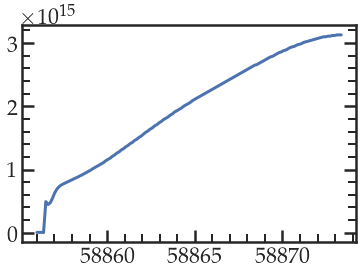

In [82]:
peakMJD = BBparams_superbol.loc[BBparams_superbol['R_bb']==np.nanmax(BBparams_superbol['R_bb']), 'ph'].values[0]
rise = BBparams_superbol.loc[BBparams_superbol['ph'] < peakMJD]
rise = rise[rise['ph'] > 0]

t_sec = (rise['ph'].values)*24*3600
r_cm = rise['R_bb'].values
m, b = np.polyfit(rise['ph'].values, r_cm, 1)

plt.plot(rise['ph'].values, r_cm)

In [84]:
BBparams_superbol

,ph,T_bb,err,R_bb,err.1,L_bb,err.2
0,58856.00,9820.0,1200.0,5.280000e+12,8.830000e+11,1.850000e+38,1.090000e+38
1,58856.13,9830.0,1200.0,5.270000e+12,8.770000e+11,1.850000e+38,1.090000e+38
2,58856.25,9440.0,8640.0,5.750000e+12,8.470000e+12,1.870000e+38,8.790000e+38
3,58856.38,19000.0,57400.0,2.730000e+12,8.050000e+12,6.990000e+38,9.380000e+39
4,58856.51,7400.0,432.0,4.920000e+14,4.990000e+13,5.160000e+41,1.600000e+41
...,...,...,...,...,...,...,...
495,58918.69,4580.0,432.0,7.700000e+14,2.230000e+14,1.860000e+41,1.290000e+41
496,58918.82,4580.0,433.0,7.670000e+14,2.230000e+14,1.850000e+41,1.280000e+41
497,58918.95,4590.0,433.0,7.650000e+14,2.220000e+14,1.840000e+41,1.280000e+41
498,58919.07,4590.0,434.0,7.620000e+14,2.220000e+14,1.830000e+41,1.270000e+41


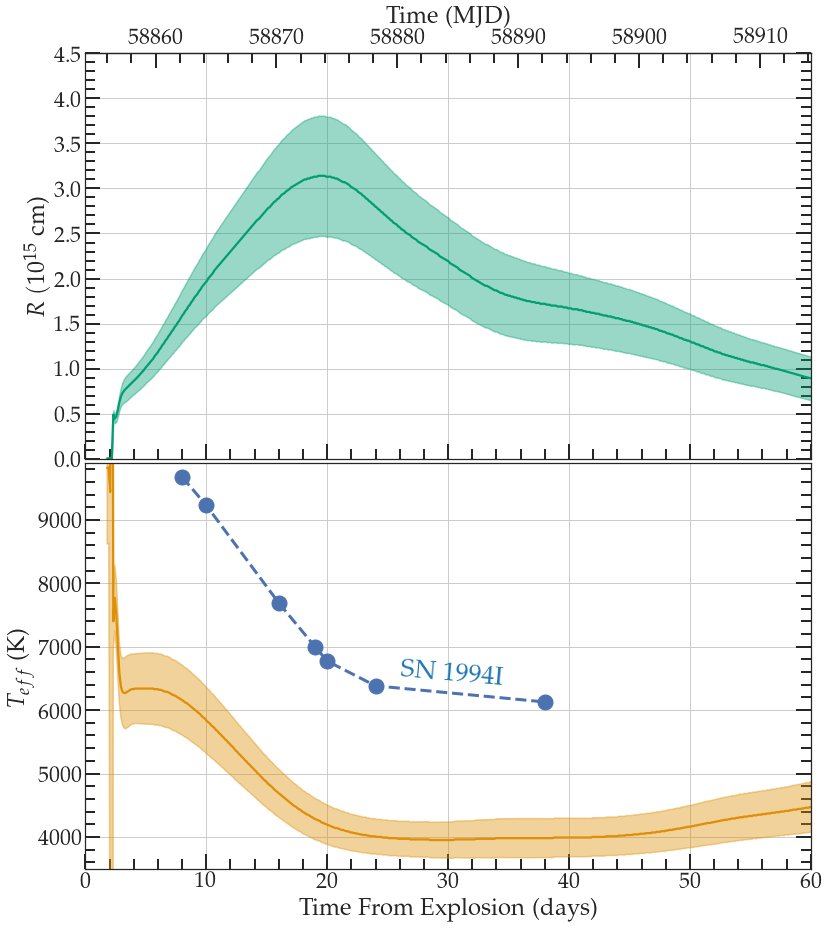

In [98]:
sns.set_context("poster")
sns.set(font_scale=2)
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
#plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

xnew = np.linspace(-2, 50)

def t0_to_mjd(x):
    return x + t0

def mjd_to_t0(x):
    return x - t0

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(13,15),sharex=True)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.01)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
    
xmax = 60
#ax1.text(4.6, 1., r"$v_{ph}$ = %.2fc"%(m/(3600*24)/2.998e10), color='gray', rotation=53, style='italic')
ax1.grid(True)
ax2.grid(True)
ax1.set_ylim((0.0, 4.5))
ax2.set_xlim((0, xmax))
ax2.set_ylim((3500, 9900))
#ax1.set_ylim(ymax=4.0)

absMJD = ax1.secondary_xaxis('top', functions=(t0_to_mjd, mjd_to_t0))
absMJD.set_xlabel('Time (MJD)')
    
absMJD.set_xlim((0+t0,xmax+t0))
ax1.plot(xnew, (m*(xnew)+b)/1.e15, 'k--', alpha=0.5, lw=3)
ax2.set_xlabel("Time From Explosion (days)")
ax1.set_ylabel(r"$R \ (10^{15}$ cm)");
ax2.set_ylabel(r"$T_{eff}$ (K)");
sns.set_context("talk")
ax1.plot(BBparams_superbol['ph']-t0, BBparams_superbol['R_bb']/1.e15, c=sns.color_palette("colorblind")[2])
ax1.fill_between(BBparams_superbol['ph']-t0, (BBparams_superbol['R_bb']-BBparams_superbol['err.1'])/1.e15, (BBparams_superbol['R_bb']+BBparams_superbol['err.1'])/1.e15, alpha=0.4, color=sns.color_palette("colorblind")[2])
ax2.plot(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb'], c=sns.color_palette("colorblind")[1])
ax2.fill_between(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb']-BBparams_superbol['err'], BBparams_superbol['T_bb']+BBparams_superbol['err'], alpha=0.4, color=sns.color_palette("colorblind")[1])
ax2.text(26, 6400, "SN 1994I", color='tab:blue',rotation=-5,fontsize=26, style='italic')
plt.plot(time_94I, T_94I, 'o--', ms=15, lw=3)
#plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/PhotoFits_MOSFiT_FancyFont.png",dpi=200, bbox_inches='tight')

Text(0.5, 1.0, '2020oi Blackbody-estimated Temperature')

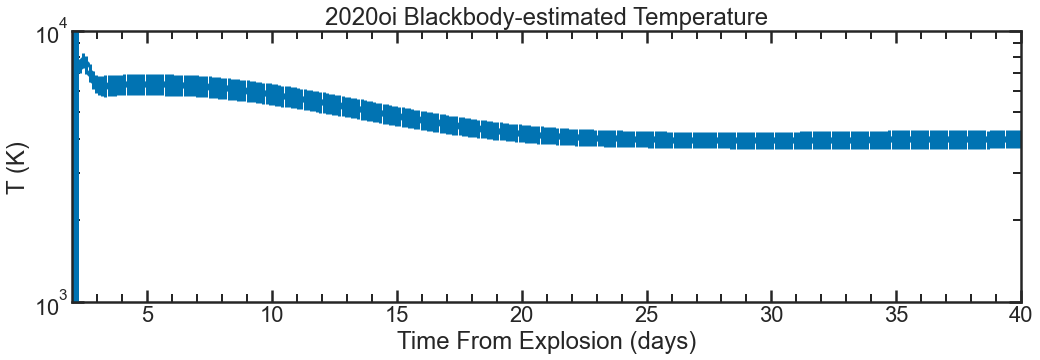

In [54]:
plt.figure(figsize=(17,5))
t0 = 58854.2

plt.errorbar(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb'], yerr=BBparams_superbol['err'], fmt='.', label=r'Superbol');
#plt.plot(BBparams_superbol['ph']-peakTime, BBparams_superbol['T_bb'], '.', label=r'Superbol');
plt.xlabel("Time From Explosion (days)")
plt.ylabel(r"T (K)")
plt.yscale("log")
plt.xlim((2, 40))
plt.ylim((1.e3, 1.e4))
plt.title("2020oi Blackbody-estimated Temperature")

In [70]:
rise = BBparams_superbol[BBparams_superbol['ph']<peakTime]

In [71]:
BBparams_superbol['ph']

0     58856.00
1     58856.57
2     58857.13
3     58857.70
4     58858.26
        ...   
95    58909.74
96    58910.30
97    58910.87
98    58911.43
99    58912.00
Name: ph, Length: 100, dtype: float64

In [73]:
t_sec = (rise['ph'].values -  58856.00)*24*3600
r_cm = rise['R_bb'].values
m, b = np.polyfit(rise['ph'].values-t0, r_cm, 1)

In [866]:
m/(3600*24)/2.998e10

NameError: name 'm' is not defined

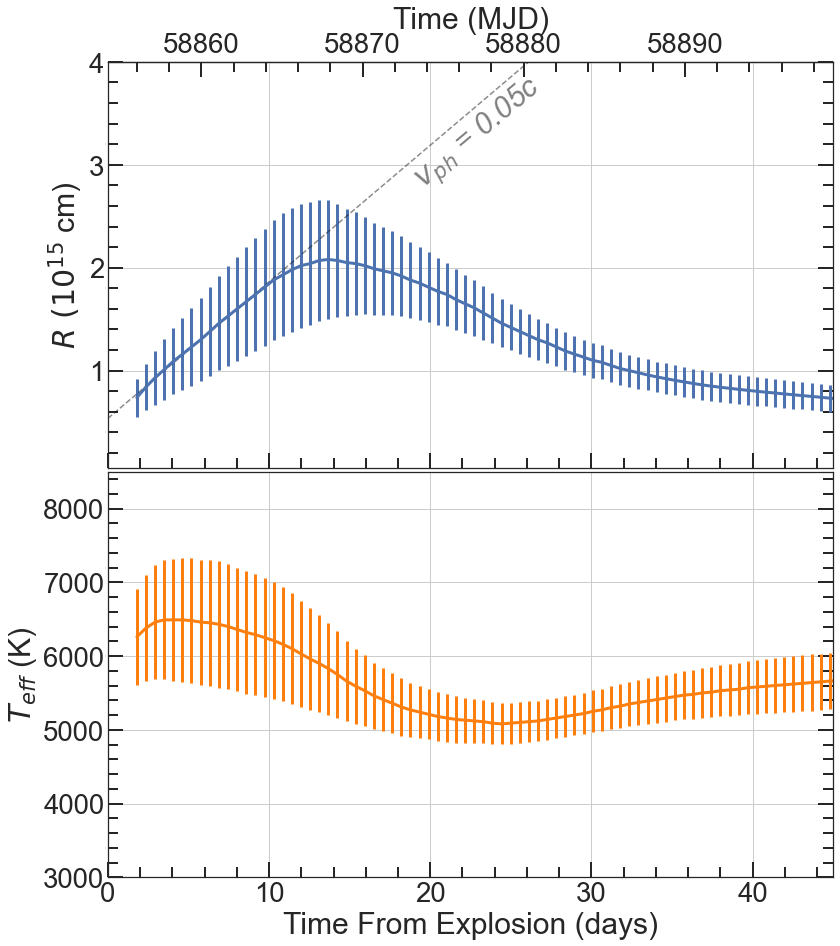

In [589]:
sns.set_context("poster")
sns.set(font_scale=2.5)
sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
#plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

xnew = np.linspace(0, 50)

def t0_to_mjd(x):
    return x + t0

def mjd_to_t0(x):
    return x - t0

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(13,15),sharex=True)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.01)

ax1.errorbar(BBparams_superbol['ph']-t0, BBparams_superbol['R_bb']/1.e15, yerr=BBparams_superbol['err.1']/1.e15, lw=3);
ax2.errorbar(BBparams_superbol['ph']-t0, BBparams_superbol['T_bb'], yerr=BBparams_superbol['err'], lw=3, c='tab:orange');
ax1.plot(xnew, (m*(xnew)+b)/1.e15, 'k--', alpha=0.5)
ax1.text(18.6, 2.8, r"$v_{ph}$ = 0.05c", color='gray', rotation=40, style='italic')
ax1.grid(True)
ax2.grid(True)
ax2.set_xlim((0, 45))
ax2.set_ylim((3000, 8500))
ax1.set_ylim(ymax=4.0)

absMJD = ax1.secondary_xaxis('top', functions=(t0_to_mjd, mjd_to_t0))
absMJD.set_xlabel('Time (MJD)')
    
absMJD.set_xlim((0+t0,45+t0))
#ax1.set_ylim((1.e14/1.e15, 2.e15/1.e15))
ax2.set_xlabel("Time From Explosion (days)")
ax1.set_ylabel(r"$R \ (10^{15}$ cm)");
ax2.set_ylabel(r"$T_{eff}$ (K)");
plt.savefig("/Users/alexgagliano/Documents/Research/2020oi/img/BBody_properties_2020oi_0217.png", bbox_inches='tight',dpi=300)

In [218]:
np.max(BBparams_superbol['R_bb'])

1360000000000000.0

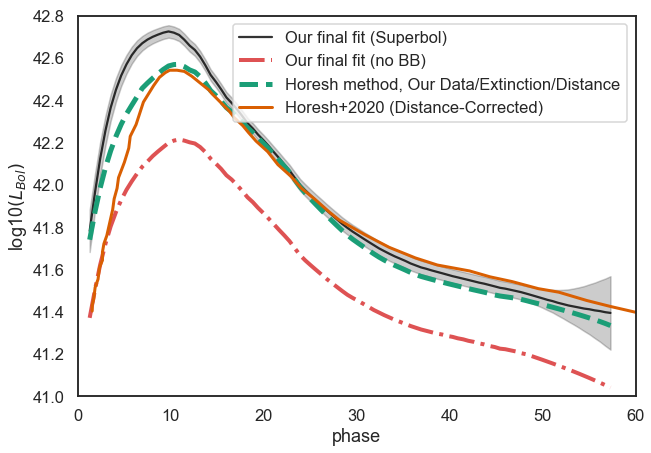

In [208]:
# new ways of estimating the bolometric luminosity, 
# using the bolometric corrections found in 
# https://academic.oup.com/mnras/article/437/4/3848/1011706#equ5
Lbol_20oi_ours = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/bol_2020oi_griz_wErr.txt")
df = pd.read_csv("../data/2020oi_griz.txt")
Mbol_20oi_theirs = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/Digitized_2020oiLbol_OtherPaper.csv", header=None, names=['phase(days)', 'MBol'])

ebv = 0.173

tStart = 58854.7

##Extinction coefficients in A_lam / E(B-V). Uses York Extinction Solver (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/YorkExtinctionSolver/coefficients.cgi)
extco = {'u': 4.786,  'g': 3.587, 'r': 2.471, 'i': 1.798,  'z': 1.403, 'y': 1.228, 'Y': 1.228,
         'U': 4.744,  'B': 4.016, 'V': 3.011, 'R': 2.386, 'G': 2.216, 'I': 1.684, 'J': 0.813, 'H': 0.516,
         'K': 0.337, 'S': 8.795, 'D': 9.270, 'A': 6.432,  'F': 8.054,  'N': 8.969, 'o': 2.185, 'c': 3.111}


# Subtract foreground extinction using input E(B-V) and coefficients from YES
df['gmag'] -= extco['g']*ebv
df['rmag'] -= extco['r']*ebv
df['imag'] -= extco['i']*ebv

#convert to absolute magnitude
d = 1.71e7 # 17.1 Mpc, distance to M100 
#d = 1.4e7 # 14 Mpc, distance used in the other paper

M_g = -5*np.log10(d/10) + df['gmag'].values
M_r = -5*np.log10(d/10) + df['rmag'].values
M_i = -5*np.log10(d/10) + df['imag'].values

col_gr = df['gmag'].values-df['rmag'].values
err_gr = np.sqrt(df['gmagerr']**2 + df['rmagerr']**2)
BCg = 0.054 - 0.195*col_gr - 0.719*col_gr**2

M_bol = M_g + BCg

Fsol = 3.83e33 # erg/s/cm
Msol = 4.77

Fbol_20oi = Fsol * 10**((Msol-M_bol)/2.5)


Mbol_20oi_theirs['MBol'] -= 1.0
Fbol_20oi_theirs = Fsol * 10**((Msol-Mbol_20oi_theirs['MBol'].values)/2.5)

plt.figure(figsize=(10,7))
#plt.plot(df['MJD'], df['gmag'], 'o')
#plt.plot(df['MJD'], df['rmag'], 'o')
#plt.plot(df['MJD'], df['imag'], 'o')
#plt.plot(df['MJD'], df['zmag'], 'o')
sns.lineplot(x=Lbol_20oi_ours['ph']-tStart, y=np.log10(Lbol_20oi_ours['L+BB']), ms=1, alpha=0.8,color='k', label='Our final fit (Superbol)')
sns.lineplot(x=Lbol_20oi_ours['ph']-tStart, y=np.log10(Lbol_20oi_ours['Lobs']), ms=1, alpha=0.8,color='tab:red', ls='-.', label='Our final fit (no BB)', lw=4)
plt.fill_between(Lbol_20oi_ours['ph']-tStart, np.log10(Lbol_20oi_ours['L+BB'])-Lbol_20oi_ours['GP_Err']/2,np.log10(Lbol_20oi_ours['L+BB'])+Lbol_20oi_ours['GP_Err']/2, alpha=0.2,color='k')
plt.plot(df['MJD']-tStart,np.log10(Fbol_20oi), '--', label='Horesh method, Our Data/Extinction/Distance', lw=5)
plt.plot(Mbol_20oi_theirs['phase(days)'], np.log10(Fbol_20oi_theirs*(17.1/14.)**2), lw=3, label='Horesh+2020 (Distance-Corrected)')
plt.xlim((0, 60))
plt.ylim((41, 42.8))
plt.ylabel(r"log10$(L_{Bol})$")
plt.xlabel("phase")
plt.legend()

In [196]:
np.log10(Lbol_20oi_ours['err'])/2

0     20.012653
1     20.086593
2     20.151598
3     20.206650
4     20.251214
        ...    
95    19.879077
96    19.877174
97    19.876024
98    19.875254
99    19.874481
Name: err, Length: 100, dtype: float64

In [193]:
Lbol_20oi_ours

,ph,Lobs,err,L+BB,err.1,GP_Err
0,58856.00,2.350000e+41,1.060000e+40,6.060000e+41,3.470000e+41,0.199788
1,58856.57,3.190000e+41,1.490000e+40,9.190000e+41,5.490000e+41,0.178537
2,58857.13,4.190000e+41,2.010000e+40,1.330000e+42,8.330000e+41,0.158986
3,58857.70,5.270000e+41,2.590000e+40,1.810000e+42,1.200000e+42,0.141193
4,58858.26,6.370000e+41,3.180000e+40,2.320000e+42,1.590000e+42,0.125211
...,...,...,...,...,...,...
95,58909.74,1.220000e+41,5.730000e+39,2.580000e+41,1.300000e+41,0.236778
96,58910.30,1.190000e+41,5.680000e+39,2.550000e+41,1.300000e+41,0.262202
97,58910.87,1.160000e+41,5.650000e+39,2.530000e+41,1.290000e+41,0.289160
98,58911.43,1.130000e+41,5.630000e+39,2.500000e+41,1.290000e+41,0.317571


In [180]:
Fbol_20oi_ourVals = np.log10(Fbol_20oi)

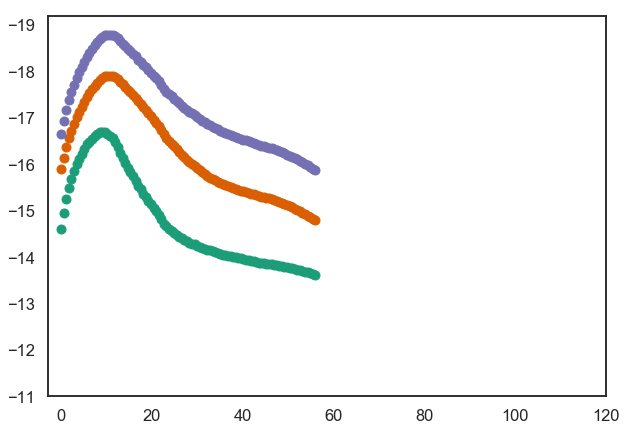

In [127]:
plt.figure(figsize=(10,7))
plt.plot(df['MJD']-df['MJD'].values[0], M_g, 'o')
plt.plot(df['MJD']-df['MJD'].values[0], M_r-1, 'o')
plt.plot(df['MJD']-df['MJD'].values[0], M_i-2, 'o')
plt.xlim((-3, 120))
plt.ylim((-19.2, -11))
plt.gca().invert_yaxis()

In [305]:
#distance modulus uncertainty
d = 1.71e7 #mpc
dL = 1.4e7 #mpc
dH = 2.0e7 #mpc
print(5*np.log10(d/10)) #pc
lowbar = 5*np.log10(d/10) - 5*np.log10(dL/10) #pc
highbar = 5*np.log10(dH/10) - 5*np.log10(d/10) #pc

31.16498055196077


In [307]:
print(lowbar)
print(highbar)

0.43434037356957944
0.34016942635913594
